In [1]:
# ===============
# IMPORT THƯ VIỆN
# ===============
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from skimage import color

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib


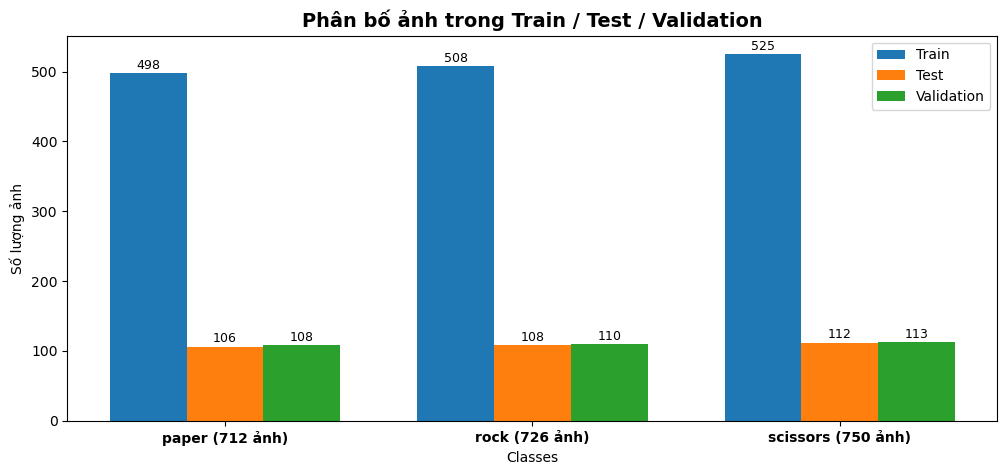

In [2]:
# ==========================
# 1) GIỚI THIỆU DỮ LIỆU
# ==========================
base_dir = r"D:\BT_KNN\dataset"  

# Hàm đếm số ảnh trong một thư mục
def count_images(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Các tập và lớp
splits = ["train", "test", "validation"]
classes = ["paper", "rock", "scissors"]

# Đếm số lượng ảnh
data_counts = {split: [] for split in splits}
for split in splits:
    for cls in classes:
        folder = os.path.join(base_dir, split, cls)
        data_counts[split].append(count_images(folder))

# Tổng số ảnh mỗi class
totals = [data_counts["train"][i] + data_counts["test"][i] + data_counts["validation"][i] for i in range(len(classes))]

# Vẽ biểu đồ
x = range(len(classes))
bar_width = 0.25
plt.figure(figsize=(12,5))
bars1 = plt.bar([i - bar_width for i in x], data_counts["train"], width=bar_width, label="Train")
bars2 = plt.bar(x, data_counts["test"], width=bar_width, label="Test")
bars3 = plt.bar([i + bar_width for i in x], data_counts["validation"], width=bar_width, label="Validation")

# Nhãn trục
xtick_labels = [f"{cls} ({totals[i]} ảnh)" for i, cls in enumerate(classes)]
plt.xticks(x, xtick_labels, fontsize=10, fontweight='bold')
plt.xlabel("Classes")
plt.ylabel("Số lượng ảnh")
plt.title("Phân bố ảnh trong Train / Test / Validation", fontsize=14, fontweight='bold')
plt.legend()

# Ghi số trên từng cột
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 2, str(height), 
                 ha='center', va='bottom', fontsize=9)
add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.show()


In [3]:
# ==========================
# 2) PREPROCESSING: đọc ảnh, resize
# ==========================
def load_data(base_path, img_size=(64,64)):
    X, y = [], []
    classes = os.listdir(base_path)
    for label in classes:
        class_path = os.path.join(base_path, label)
        if not os.path.isdir(class_path):
            continue
        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

# Load dữ liệu
X_train, y_train = load_data(os.path.join(base_dir, "train"))
X_val,   y_val   = load_data(os.path.join(base_dir, "validation"))
X_test,  y_test  = load_data(os.path.join(base_dir, "test"))

print("Train:", X_train.shape, "Valid:", X_val.shape, "Test:", X_test.shape)

# Encode nhãn chữ thành số
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val   = le.transform(y_val)
y_test  = le.transform(y_test)


Train: (1531, 64, 64, 3) Valid: (331, 64, 64, 3) Test: (326, 64, 64, 3)


In [4]:
# ==========================
# 3) TRÍCH XUẤT ĐẶC TRƯNG HOG
# ==========================
def extract_hog(images):
    feats = []
    for img in images:
        gray = color.rgb2gray(img)
        hog_feat = hog(gray, pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_hog = extract_hog(X_train)
X_val_hog   = extract_hog(X_val)
X_test_hog  = extract_hog(X_test)

print("HOG Train:", X_train_hog.shape)


HOG Train: (1531, 1764)


In [5]:
# ==========================
# 4) CHUẨN HÓA + GIẢM CHIỀU PCA
# ==========================
scaler = StandardScaler()
X_train_hog = scaler.fit_transform(X_train_hog)
X_val_hog   = scaler.transform(X_val_hog)
X_test_hog  = scaler.transform(X_test_hog)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_hog)
X_val_pca   = pca.transform(X_val_hog)
X_test_pca  = pca.transform(X_test_hog)

print("PCA Train:", X_train_pca.shape)


PCA Train: (1531, 100)


k=1 → Val Acc=0.9819
k=2 → Val Acc=0.9819
k=3 → Val Acc=0.9819
k=4 → Val Acc=0.9819
k=5 → Val Acc=0.9789
k=6 → Val Acc=0.9819
k=7 → Val Acc=0.9819
k=8 → Val Acc=0.9819
k=9 → Val Acc=0.9819
k=10 → Val Acc=0.9849
k=11 → Val Acc=0.9819
k=12 → Val Acc=0.9819
k=13 → Val Acc=0.9789
k=14 → Val Acc=0.9758
k=15 → Val Acc=0.9728
k=16 → Val Acc=0.9728
k=17 → Val Acc=0.9698
k=18 → Val Acc=0.9698
k=19 → Val Acc=0.9698
k=20 → Val Acc=0.9698
k=21 → Val Acc=0.9698


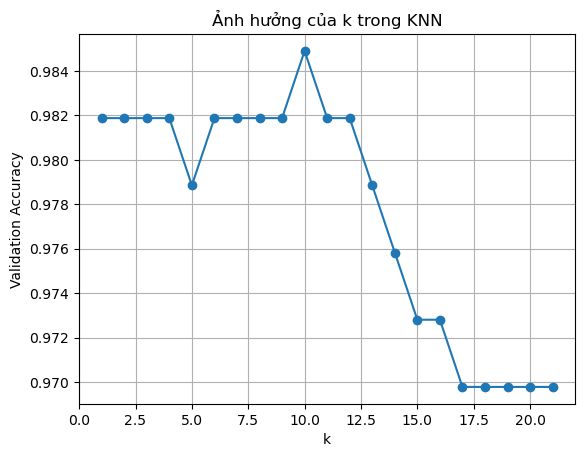


Best k = 10 Val Accuracy = 0.9848942598187311


In [6]:
# ==========================
# 5) KNN + TÌM BEST k
# ==========================
accs, k_values = [], range(1,22)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean", weights="distance")
    knn.fit(X_train_pca, y_train)
    accs.append(knn.score(X_val_pca, y_val))
    print(f"k={k} → Val Acc={accs[-1]:.4f}")

plt.plot(k_values, accs, marker="o")
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Ảnh hưởng của k trong KNN")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accs)]
print("\nBest k =", best_k, "Val Accuracy =", max(accs))



Classification Report:
              precision    recall  f1-score   support

       paper       0.97      0.97      0.97       106
        rock       1.00      0.99      1.00       108
    scissors       0.96      0.97      0.97       112

    accuracy                           0.98       326
   macro avg       0.98      0.98      0.98       326
weighted avg       0.98      0.98      0.98       326



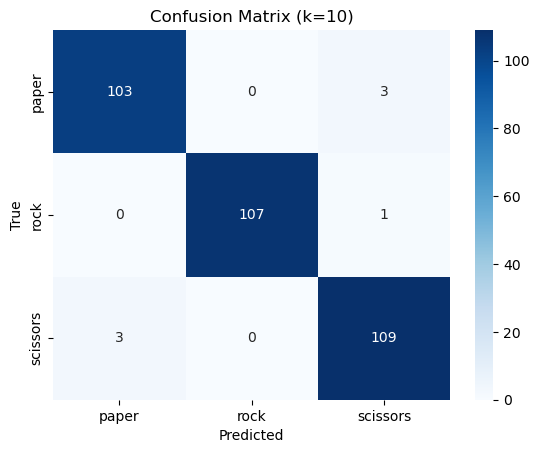

In [ ]:
# ============================
# 6) ĐÁNH GIÁ MÔ HÌNH TRÊN TEST
# ============================
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="euclidean", weights="distance")
knn_final.fit(X_train_pca, y_train)

y_pred = knn_final.predict(X_test_pca)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (k={best_k})")
plt.show()


In [9]:
# ==========================
# 7) LƯU MÔ HÌNH & PIPELINE
# ==========================
os.makedirs("model", exist_ok=True)

joblib.dump(knn_final, "model/knn_model.pkl")
joblib.dump(scaler, "model/scaler.pkl")
joblib.dump(pca, "model/pca.pkl")
joblib.dump(le, "model/label_encoder.pkl")

print("Đã lưu model vào folder model")


Đã lưu model vào folder model


In [ ]:
# ======================
# 8) DỰ ĐOÁN 1 ẢNH NGOÀI
# ======================
    
# --- Load lại pipeline đã train ---
knn_final = joblib.load("model/knn_model.pkl")
scaler    = joblib.load("model/scaler.pkl")
pca       = joblib.load("model/pca.pkl")
le        = joblib.load("model/label_encoder.pkl")

# --- Hàm dự đoán ---
def predict_single(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Không đọc được ảnh, kiểm tra lại đường dẫn!")
    img = cv2.resize(img, (64,64))

    gray = color.rgb2gray(img)
    hog_feat = hog(gray, pixels_per_cell=(8,8),
                   cells_per_block=(2,2),
                   feature_vector=True)
    
    hog_feat = scaler.transform([hog_feat])
    hog_feat = pca.transform(hog_feat)

    pred = knn_final.predict(hog_feat)[0]
    label = le.inverse_transform([pred])[0]

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Dự đoán: {label}")
    plt.axis("off")
    plt.show()
    return label

# --- Ví dụ chạy ---
predict_single(r"Bao.jpg")


In [ ]:
# ===============================
# 9) DỰ ĐOÁN REAL-TIME QUA CAMERA
# ===============================

# --- Load lại pipeline đã lưu ---
knn_final = joblib.load("model/knn_model.pkl")
scaler    = joblib.load("model/scaler.pkl")
pca       = joblib.load("model/pca.pkl")
le        = joblib.load("model/label_encoder.pkl")

# --- Hàm dự đoán từ 1 frame ---
def predict_from_frame(frame, img_size=(64,64)):
    # Resize về cùng kích thước
    img_resized = cv2.resize(frame, img_size)

    # Chuyển grayscale + HOG
    gray = color.rgb2gray(img_resized)
    hog_feat = hog(gray, pixels_per_cell=(8,8),
                   cells_per_block=(2,2),
                   feature_vector=True)

    # Chuẩn hóa + PCA
    hog_feat = scaler.transform([hog_feat])
    hog_feat = pca.transform(hog_feat)

    # Dự đoán bằng KNN
    pred = knn_final.predict(hog_feat)[0]
    return le.inverse_transform([pred])[0]

# --- Mở webcam ---
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    h, w, _ = frame.shape
    x1, y1, x2, y2 = w//3, h//3, 2*w//3, 2*h//3
    cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

    roi = frame[y1:y2, x1:x2]
    if roi.size > 0:
        label = predict_from_frame(roi)
        cv2.putText(frame, f"Prediction: {label}", (10,40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,255), 3)

    cv2.imshow("Rock-Paper-Scissors (KNN Webcam)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
